In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from linearmodels.panel import FamaMacBeth
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Import Data
# raw_df = pd.read_sas("/Users/jackeylove/Library/CloudStorage/OneDrive-Personal/Learn/Undergraduate/WT 3/CFM 301/Final Project/signals_raw_plus.sas7bdat")
gross_df = pd.read_sas("./merged_df.sas7bdat") # just keep the file in the same folder

# raw_df.to_excel("raw_df.xlsx", index=False)
# gross_df.to_excel("gross_df.xlsx", index=False)

# Data Cleaning
df = gross_df[gross_df["yyyymm"] >= 198001].copy()

# Price must exceed $5.
# Market cap must be at least $100 million.
df["mktcap"] = df["PRC"] * df["SHROUT"] * 1000
jan_df = df[df["yyyymm"] % 100 == 1].copy()
qualified_jan = jan_df[(jan_df["PRC"] > 5) & (jan_df["mktcap"] >= 100e6)]

qualified_stocks = qualified_jan["permno"].unique()
filtered_df = df[df["permno"].isin(qualified_stocks)].copy()

# List of all potential columns/factors (commenting out the ones not in current use).
# Feel free to uncomment any factor you want to include in the future.
cols_to_keep = [
    # Basic identifiers
    "permno",
    "yyyymm",
    # "monthid",
    # "ticker",
    # "conm",
    # "gvkey",
    # "cusip",
    # "naics",
    # "gsubind",

    # Current factors in use
    "IM",
    "range_20",
    "log_vol_dollar_20",
    "range_120",
    "log_vol_dollar_120",
    "xret_5",
    "xret_10",
    "xret_20",
    "xret_indsize_20",
    "xret_indsize_std20",
    "xret_40",
    "xret_120",
    "xret_indsize_120",
    "xret_indsize_std120",
    "KDJ_20",
    "deviation_pct20",
    "MoneyFlowIndex_20",
    "RSI_20",
    "KDJ_120",
    "deviation_pct120",
    "MoneyFlowIndex_120",
    "RSI_120",
    "IV_capm",
    "mdr",
    "ami_3",
    "beta_3y",
    "beta_5y",
    "tail_2y",
    "dp",
    "leverage",
    "BL",
    "roe",
    "roa",
    "profitability",
    "sales_g_q",
    "sales_g_ttm",
    "op_income_g_q",
    "ni_g_q",
    "op_income_g_ttm",
    "ni_g_ttm",
    "sue_NI",
    "BM",
    "AM",
    "EP",
    "SP",
    "roe_q",
    "roa_q",
    "Cto",
    "pe_ttm",
    "lag_log_size",

    # Price, Volume, Returns, and Shares Outstanding
    "PRC",
    "VOL",
    "RET",
    "SHROUT",

    # Future returns (commented out for now)
    # "ret_f1",
    # "ret_f2",
    # "ret_f3",
    # "ret_f4",
    # "ret_f5",
    # "ret_f6",
    # "ret_f7",
    # "ret_f8",
    # "ret_f9",
    # "ret_f10",
    # "ret_f11",
    # "ret_f12"
]

filtered_df = filtered_df[cols_to_keep]
# filtered_df
# filtered_df.to_excel("filtered_df.xlsx", index=False)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Use first 3/4 of data time period for return predictions and model validation
in_sample_df = filtered_df[filtered_df["yyyymm"] < 201001].copy()
out_of_sample_df = filtered_df[filtered_df["yyyymm"] >= 201001].copy()

in_sample_df
# out_of_sample_df

factors = [col for col in cols_to_keep if col not in ["permno", "yyyymm", "PRC", "VOL", "RET", "SHROUT"] + ["ret_f" + str(x) for x in range(1, 13)]]

# Drop rows with missing predictor or RET values
in_sample_df.dropna(subset=factors + ["RET"], inplace=True)

# Standardized values of each of your factors of each month
for f in factors:
    means = in_sample_df.groupby("yyyymm")[f].transform("mean")
    stds = in_sample_df.groupby("yyyymm")[f].transform("std")
    in_sample_df[f + "_z"] = (in_sample_df[f] - means) / stds if not any(x == 0 for x in stds) else in_sample_df[f] - means

in_sample_df

,permno,yyyymm,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,xret_20,...,sue_NI_z,BM_z,AM_z,EP_z,SP_z,roe_q_z,roa_q_z,Cto_z,pe_ttm_z,lag_log_size_z
26,10026.0,198803.0,-0.169949,0.022356,11.448653,0.034842,11.532350,-0.012147,-0.006940,0.015151,...,0.373546,-0.711062,-0.357720,-0.004743,-0.407866,0.242501,-0.080060,-0.194748,-0.286526,-1.356820
27,10026.0,198804.0,-0.156519,0.028751,11.430663,0.037007,11.367310,-0.027687,-0.019194,0.088784,...,0.355288,-0.701346,-0.344750,-0.004638,-0.405633,0.218745,-0.071566,-0.204867,-0.279014,-1.309497
28,10026.0,198805.0,-0.139082,0.021252,11.130541,0.030415,11.219991,-0.013430,-0.041029,0.000236,...,-0.511862,-0.782942,-0.375150,-0.070217,-0.441855,-0.089769,-0.296920,-0.108328,-0.217596,-1.292732
29,10026.0,198806.0,0.055752,0.026280,11.276720,0.028368,11.272204,-0.018349,-0.111331,-0.141110,...,-0.552436,-0.800969,-0.342425,-0.060231,-0.425248,-0.188243,-0.351458,-0.085105,-0.213490,-1.379931
30,10026.0,198807.0,0.144300,0.034056,11.624352,0.028654,11.357047,0.028193,0.096229,0.135331,...,-0.527847,-0.803142,-0.337808,-0.062985,-0.424193,-0.178486,-0.354425,-0.086446,-0.218347,-1.250161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436865,92655.0,200908.0,-0.018304,0.046298,19.387276,0.055906,19.478186,0.019206,0.060651,0.062170,...,1.214846,-0.105999,-0.198550,0.253999,0.094480,0.153191,0.263043,0.842134,-0.731523,1.769459
436866,92655.0,200909.0,0.358881,0.034559,19.331270,0.049051,19.405474,-0.052035,-0.056767,0.012294,...,1.140807,-0.049402,-0.171298,0.315117,0.299053,0.156772,0.243840,0.816033,-0.754259,1.745899
436867,92655.0,200910.0,0.772017,0.038173,19.595972,0.044826,19.455340,-0.057280,-0.141148,-0.147458,...,1.125310,-0.047297,-0.171175,0.324576,0.319528,0.144596,0.240494,0.814044,-0.757101,1.660082
436868,92655.0,200911.0,0.559749,0.032542,19.636446,0.040175,19.467873,0.053381,0.119833,0.066962,...,0.273106,0.084231,-0.129217,0.352395,0.572680,0.206306,0.266082,0.789828,-0.795769,1.674294


In [ ]:
standardized_factors = [f + "_z" for f in factors]

# Fama-MacBeth Regression
panel_df = in_sample_df.copy()
panel_df = panel_df.set_index(["permno", "yyyymm"])

# Define X and y
X = panel_df[standardized_factors]
X = sm.add_constant(X)
y = panel_df["RET"]

# Fit the Fama-MacBeth model
fmb_model = FamaMacBeth(y, X)
fmb_results = fmb_model.fit()
print(fmb_results.summary)
f = open("fmb_results.csv", "a")
f.write(fmb_results.summary.as_csv())
f.close()

C:\Users\germa\AppData\Local\Temp\ipykernel_26940\951764028.py:13: MissingValueWarning: 34 of the time-series regressions cannot be estimated due to deficient rank.
  fmb_model = FamaMacBeth(y, X)


                             FamaMacBeth Estimation Summary                            
Dep. Variable:                           RET   R-squared:                        0.0065
Estimator:                       FamaMacBeth   R-squared (Between):              0.1109
No. Observations:                     210640   R-squared (Within):               0.0064
Date:                       Sun, Apr 20 2025   R-squared (Overall):              0.0065
Time:                               23:00:24   Log-likelihood                 1.375e+05
Cov. Estimator:    Fama-MacBeth Standard Cov                                           
                                               F-statistic:                      27.578
Entities:                               1113   P-value                           0.0000
Avg Obs:                              189.25   Distribution:               F(50,210589)
Min Obs:                              1.0000                                           
Max Obs:                        

In [ ]:
# FMB REGRESSION V2
# Alan

standardized_factors = [f + "_z" for f in factors]

# Fama-MacBeth Regression
factor_betas = {}
for permno, group in in_sample_df.groupby('permno'):
    group_ind = group[standardized_factors]
    factor_model = linear_model.LinearRegression().fit(group[standardized_factors], group['RET'])
    factor_betas.update({permno: factor_model.coef_})

for i in range(len(standardized_factors)):
    in_sample_df[standardized_factors[i] + "_beta"] = in_sample_df['permno'].apply(lambda x: factor_betas[x][i])

in_sample_df[[x + "_beta" for x in standardized_factors]]

C:\Users\germa\AppData\Local\Temp\ipykernel_26940\3587022935.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  in_sample_df[standardized_factors[i] + "_beta"] = in_sample_df['permno'].apply(lambda x: factor_betas[x][i])


,IM_z_beta,range_20_z_beta,log_vol_dollar_20_z_beta,range_120_z_beta,log_vol_dollar_120_z_beta,xret_5_z_beta,xret_10_z_beta,xret_20_z_beta,xret_indsize_20_z_beta,xret_indsize_std20_z_beta,...,sue_NI_z_beta,BM_z_beta,AM_z_beta,EP_z_beta,SP_z_beta,roe_q_z_beta,roa_q_z_beta,Cto_z_beta,pe_ttm_z_beta,lag_log_size_z_beta
26,0.019231,0.010462,0.070578,-0.058174,-0.188983,0.010650,0.024332,0.020479,0.005095,-0.007264,...,0.017407,-0.126810,0.255738,0.117103,-0.069397,-0.012283,-0.009300,-0.023615,-0.12978,-0.144288
27,0.019231,0.010462,0.070578,-0.058174,-0.188983,0.010650,0.024332,0.020479,0.005095,-0.007264,...,0.017407,-0.126810,0.255738,0.117103,-0.069397,-0.012283,-0.009300,-0.023615,-0.12978,-0.144288
28,0.019231,0.010462,0.070578,-0.058174,-0.188983,0.010650,0.024332,0.020479,0.005095,-0.007264,...,0.017407,-0.126810,0.255738,0.117103,-0.069397,-0.012283,-0.009300,-0.023615,-0.12978,-0.144288
29,0.019231,0.010462,0.070578,-0.058174,-0.188983,0.010650,0.024332,0.020479,0.005095,-0.007264,...,0.017407,-0.126810,0.255738,0.117103,-0.069397,-0.012283,-0.009300,-0.023615,-0.12978,-0.144288
30,0.019231,0.010462,0.070578,-0.058174,-0.188983,0.010650,0.024332,0.020479,0.005095,-0.007264,...,0.017407,-0.126810,0.255738,0.117103,-0.069397,-0.012283,-0.009300,-0.023615,-0.12978,-0.144288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436865,0.013774,-0.004811,-0.056825,0.106776,0.182878,0.007081,0.022718,0.053191,-0.089500,-0.034048,...,0.026234,0.066103,0.006248,-0.041780,-0.071115,0.028068,-0.050089,0.009196,-0.03970,-0.182900
436866,0.013774,-0.004811,-0.056825,0.106776,0.182878,0.007081,0.022718,0.053191,-0.089500,-0.034048,...,0.026234,0.066103,0.006248,-0.041780,-0.071115,0.028068,-0.050089,0.009196,-0.03970,-0.182900
436867,0.013774,-0.004811,-0.056825,0.106776,0.182878,0.007081,0.022718,0.053191,-0.089500,-0.034048,...,0.026234,0.066103,0.006248,-0.041780,-0.071115,0.028068,-0.050089,0.009196,-0.03970,-0.182900
436868,0.013774,-0.004811,-0.056825,0.106776,0.182878,0.007081,0.022718,0.053191,-0.089500,-0.034048,...,0.026234,0.066103,0.006248,-0.041780,-0.071115,0.028068,-0.050089,0.009196,-0.03970,-0.182900


 ## Ignore this text block i didnt end up using this

 ## Transformation of Risk Premia for Panel-Form Asset-Unique Factors

 The traditional Fama-MacBeth model finds risk premia for each unit of risk (beta) for each factor. This works for factors that only have a degree of freedom across time, and are identical across portfolios (e.g. HML, SMB, Market Excess Return).

 We change the second half of the regression to instead calculate the **risk premia proportionality** with respect to the factor value at time $t$ (since this is a predictive factor model, the factor described is already realized at time $t-1$).

 The theory is at time $t$, the risk premia proportionality $R_{i, t}$ w.r.t. $F_{k, (i, t)}$ for a fixed month $i$ should be the same for each portfolio $i$ (or stock $i$). Additionally, the value *should* be 1, i.e. the risk premia should be directly proportional to $F_{i, t}$.

 (note the index for $F$ is $k, (i, t)$ for the $k$th factor, the $i$th portfolio, and time period $t$, instead of $k, t$!)

In [ ]:
lambda_t = pd.DataFrame(columns = [x + "_beta" for x in standardized_factors])

for date, group in in_sample_df.groupby('yyyymm'):
    fmb_independent = sm.add_constant(group[[x + "_beta" for x in standardized_factors]])
    fmb_dependent = group['RET']

    fmb_model = sm.OLS(fmb_dependent, fmb_independent).fit()

    lambda_t.loc[len(lambda_t)] = fmb_model.params

lambda_t_stats = pd.DataFrame()
lambda_t_stats['mean'] = lambda_t.mean()
lambda_t_stats['stderr'] = lambda_t.std() / len(lambda_t) ** 0.5
lambda_t_stats['tstat'] = lambda_t_stats['mean'] / lambda_t_stats['stderr']
lambda_t_stats = lambda_t_stats.rename(lambda x: x[:-5])

print(abs(lambda_t_stats['tstat']).sort_values())
lambda_t_stats

leverage_z               0.012400
lag_log_size_z           0.017803
roe_z                    0.054321
log_vol_dollar_20_z      0.055708
ni_g_ttm_z               0.058421
beta_5y_z                0.089841
AM_z                     0.126828
beta_3y_z                0.168522
roe_q_z                  0.183852
xret_120_z               0.198283
dp_z                     0.246798
BL_z                     0.251977
SP_z                     0.255191
xret_indsize_120_z       0.300063
MoneyFlowIndex_20_z      0.337422
profitability_z          0.344396
Cto_z                    0.353866
KDJ_120_z                0.383396
sales_g_ttm_z            0.417856
roa_q_z                  0.428305
ami_3_z                  0.480761
sales_g_q_z              0.485867
EP_z                     0.537543
xret_5_z                 0.558768
range_120_z              0.594640
xret_40_z                0.621993
deviation_pct120_z       0.622844
deviation_pct20_z        0.683991
op_income_g_ttm_z        0.797499
pe_ttm_z      

,mean,stderr,tstat
IM_z,0.020029,0.022121,0.905417
range_20_z,-0.014885,0.010598,-1.404556
log_vol_dollar_20_z,0.000253,0.004534,0.055708
range_120_z,0.002941,0.004945,0.594640
log_vol_dollar_120_z,0.002824,0.002656,1.063098
xret_5_z,-0.017653,0.031592,-0.558768
xret_10_z,-0.031566,0.029870,-1.056755
xret_20_z,-0.036338,0.025462,-1.427118
xret_indsize_20_z,-0.027837,0.026488,-1.050914
xret_indsize_std20_z,-0.023775,0.014857,-1.600186


 # Eliminating Collinearity

 First, we elimiate collinear variables from the dataset. Then, we rerun the Fama-Macbeth regression to show the efficacy of our factor model.

In [ ]:
# choosing a subset of the variables to run the regression
factor_subset = [
    'log_vol_dollar_120_z',
    'BM_z',
    'range_20_z',
    'xret_20_z',
    'mdr_z',
    'xret_indsize_std20_z',
    'IV_capm_z',
    'MoneyFlowIndex_120_z',
    'xret_indsize_20_z'
]

factor_subset_df = in_sample_df[factor_subset + ['permno', 'yyyymm', 'RET']].copy()
factor_subset_df.head()

,log_vol_dollar_120_z,BM_z,range_20_z,xret_20_z,mdr_z,xret_indsize_std20_z,IV_capm_z,MoneyFlowIndex_120_z,xret_indsize_20_z,permno,yyyymm,RET
26,-0.929936,-0.711062,-0.301353,-0.114563,-0.549154,-0.023887,-0.203738,0.027113,-0.010789,10026.0,198803.0,0.092308
27,-0.957143,-0.701346,0.161835,0.721398,1.020173,0.829614,0.639439,-0.862099,-0.053152,10026.0,198804.0,0.014085
28,-0.987180,-0.782942,-0.310751,-0.032594,0.437900,0.232103,0.348069,-0.493522,-0.200566,10026.0,198805.0,-0.125000
29,-0.979358,-0.800969,0.376265,-1.983693,0.779473,0.868606,0.784642,-0.388182,-2.072897,10026.0,198806.0,0.253968
30,-0.912896,-0.803142,0.750891,1.498837,0.492083,0.627073,0.604722,-0.188703,1.493177,10026.0,198807.0,0.025316


In [ ]:
import seaborn as sb

                      log_vol_dollar_120_z         BM_z   range_20_z  \
log_vol_dollar_120_z           1109.000000  -325.609071    11.107054   
BM_z                           -325.609071  1109.000000    -6.515085   
range_20_z                       11.107054    -6.515085  1109.000000   
xret_20_z                       -82.814138    66.268970    58.785964   
mdr_z                           -59.679444    44.105559   616.281230   
xret_indsize_std20_z           -107.624001    32.704063   781.654584   
IV_capm_z                       -65.712755    23.819841   781.021062   
MoneyFlowIndex_120_z            -68.132342   -66.655398   -36.984905   
xret_indsize_20_z               -74.395805    65.839751    58.402363   

                        xret_20_z        mdr_z  xret_indsize_std20_z  \
log_vol_dollar_120_z   -82.814138   -59.679444           -107.624001   
BM_z                    66.268970    44.105559             32.704063   
range_20_z              58.785964   616.281230            781.6

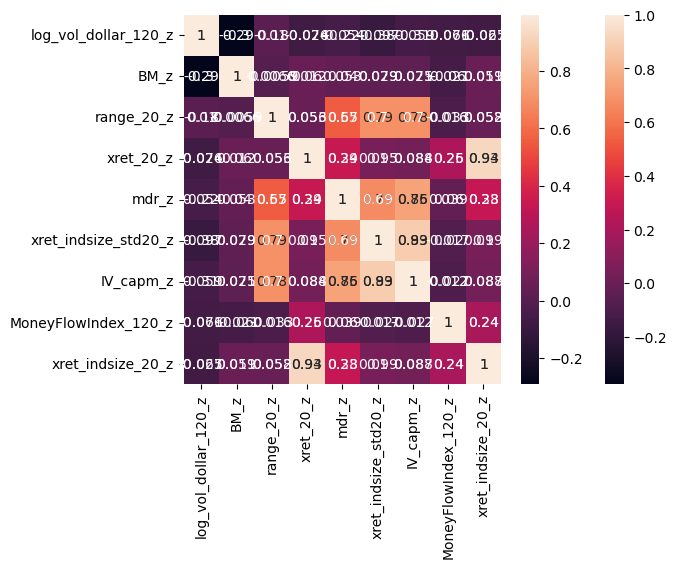

In [ ]:
dataplot = sb.heatmap(factor_subset_df[factor_subset].corr(numeric_only=True), annot=True)
corr_sum = factor_subset_df[factor_subset].corr()
corr_sum.loc[:, :] = 0
stock_count = 0
for permno, group in factor_subset_df.groupby('permno'):
    stock_count += 1
    if len(group) < 3:
        continue
    temp = group[factor_subset].corr()
    corr_sum = temp + corr_sum

print(corr_sum)
dataplot = sb.heatmap(corr_sum / stock_count, annot=True)
# Displaying heatmap
plt.show()

 Based on the above variables we notice that idiosyncratic volatility (IV_capm_z) has a rho of more than 0.7 with two other variables, and industry adjusted excess return also has a rho greater than 0.7 with excess return before adjustment (xret_indsize_20_z, xret_20_z). We will keep the industry adjusted data and remove IV_capm_z and xret_20_z.

 We will also remove range_20_z, as price range as a factor is intended to price in the volatility of a stock, already accounted for through the industry-adjusted standard deviation (between which there is a high magnitude rho of 0.7).

 Now, with our final subset of factors, our hypothesis is that market participant activity, such as trading volume, maximum daily return of the past month, money flow index, etc. accounts for the

In [ ]:
factor_subset_ii = [
    'log_vol_dollar_120_z',
    'BM_z',
    'mdr_z',
    'xret_indsize_std20_z',
    'MoneyFlowIndex_120_z',
    'xret_indsize_20_z'
]

factor_subset_ii_df = in_sample_df[factor_subset_ii + ['permno', 'yyyymm', 'RET']].copy()
factor_subset_ii_df.head()

,log_vol_dollar_120_z,BM_z,mdr_z,xret_indsize_std20_z,MoneyFlowIndex_120_z,xret_indsize_20_z,permno,yyyymm,RET
26,-0.929936,-0.711062,-0.549154,-0.023887,0.027113,-0.010789,10026.0,198803.0,0.092308
27,-0.957143,-0.701346,1.020173,0.829614,-0.862099,-0.053152,10026.0,198804.0,0.014085
28,-0.987180,-0.782942,0.437900,0.232103,-0.493522,-0.200566,10026.0,198805.0,-0.125000
29,-0.979358,-0.800969,0.779473,0.868606,-0.388182,-2.072897,10026.0,198806.0,0.253968
30,-0.912896,-0.803142,0.492083,0.627073,-0.188703,1.493177,10026.0,198807.0,0.025316


 Let's check the correlation matrices once again

                      log_vol_dollar_120_z         BM_z        mdr_z  \
log_vol_dollar_120_z           1109.000000  -325.609071   -59.679444   
BM_z                           -325.609071  1109.000000    44.105559   
mdr_z                           -59.679444    44.105559  1109.000000   
xret_indsize_std20_z           -107.624001    32.704063   765.211363   
MoneyFlowIndex_120_z            -68.132342   -66.655398    43.111706   
xret_indsize_20_z               -74.395805    65.839751   363.969775   

                      xret_indsize_std20_z  MoneyFlowIndex_120_z  \
log_vol_dollar_120_z           -107.624001            -68.132342   
BM_z                             32.704063            -66.655398   
mdr_z                           765.211363             43.111706   
xret_indsize_std20_z           1109.000000            -19.231500   
MoneyFlowIndex_120_z            -19.231500           1109.000000   
xret_indsize_20_z               113.315653            271.976004   

                  

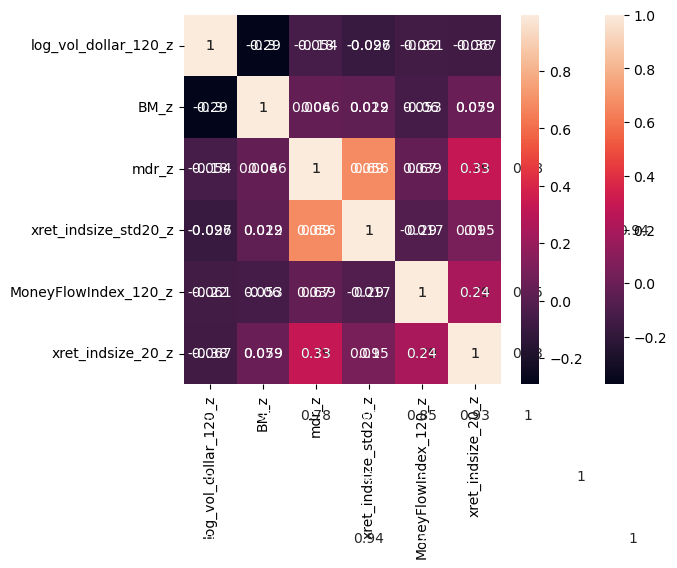

In [ ]:
dataplot = sb.heatmap(factor_subset_df[factor_subset].corr(numeric_only=True), annot=True)
corr_sum = factor_subset_ii_df[factor_subset_ii].corr()
corr_sum.loc[:, :] = 0
stock_count = 0
for permno, group in factor_subset_ii_df.groupby('permno'):
    stock_count += 1
    if len(group) < 3:
        continue
    corr_sum = group[factor_subset_ii].corr() + corr_sum

print(corr_sum)
dataplot_ii = sb.heatmap(corr_sum / stock_count, annot=True)
# Displaying heatmap
plt.show()

 The correlation matrix looks good. The one part that may raise concern is the industry adjusted standard deviation correlating with the maximum daily return from the past month, but we believe the two variables express differing information about investor sentiment.

 We now go ahead with the Fama-Macbeth Regression.

 # Second Run of Fama-Macbeth

In [ ]:
# Fama-MacBeth Regression
factor_betas = {}
for permno, group in factor_subset_ii_df.groupby('permno'):
    factor_model = linear_model.LinearRegression().fit(group[factor_subset_ii], group['RET'])
    factor_betas.update({permno: factor_model.coef_})

for i in range(len(factor_subset_ii)):
    factor_subset_ii_df[factor_subset_ii[i] + "_beta"] = factor_subset_ii_df['permno'].apply(lambda x: factor_betas[x][i])

factor_subset_ii_df[[x + "_beta" for x in factor_subset_ii]]

,log_vol_dollar_120_z_beta,BM_z_beta,mdr_z_beta,xret_indsize_std20_z_beta,MoneyFlowIndex_120_z_beta,xret_indsize_20_z_beta
26,-0.084061,-0.016793,-0.017117,0.002928,-0.001352,-0.006543
27,-0.084061,-0.016793,-0.017117,0.002928,-0.001352,-0.006543
28,-0.084061,-0.016793,-0.017117,0.002928,-0.001352,-0.006543
29,-0.084061,-0.016793,-0.017117,0.002928,-0.001352,-0.006543
30,-0.084061,-0.016793,-0.017117,0.002928,-0.001352,-0.006543
...,...,...,...,...,...,...
436865,-0.007707,-0.042548,0.011323,-0.009740,-0.001390,-0.013683
436866,-0.007707,-0.042548,0.011323,-0.009740,-0.001390,-0.013683
436867,-0.007707,-0.042548,0.011323,-0.009740,-0.001390,-0.013683
436868,-0.007707,-0.042548,0.011323,-0.009740,-0.001390,-0.013683


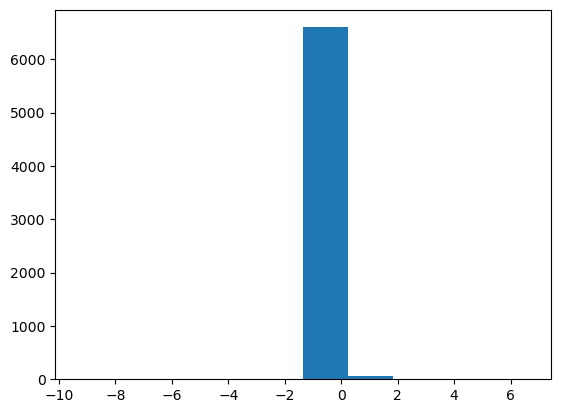

In [ ]:
beta_values = []
for c in [x + "_beta" for x in factor_subset_ii]:
    beta_values += factor_subset_ii_df[c].unique().tolist()

plt.hist(beta_values)
plt.show()

 A previous issue we had after we finalized our FMB regression is that we used too many factors, leading to collinearity when adding a constant term in the regression, also resulting in extremely blown-up beta values in the hundreds. These beta values seem more reasonable. The issue seems to be resolved here, where some blown-up values still appear, but are smaller, and mostly due to overfitting on a limited number of data points for stocks with spotty history.

 We will set a minimum number of data points when running the actual backtest.

In [ ]:
# Second Pass of Fama-MacBeth
lambda_t = pd.DataFrame(columns = [x + "_beta" for x in factor_subset_ii])

for date, group in factor_subset_ii_df.groupby('yyyymm'):
    fmb_independent = sm.add_constant(group[[x + "_beta" for x in factor_subset_ii]])
    fmb_dependent = group['RET']

    fmb_model = sm.OLS(fmb_dependent, fmb_independent).fit()

    lambda_t.loc[len(lambda_t)] = fmb_model.params

lambda_t_stats = pd.DataFrame()
lambda_t_stats['mean'] = lambda_t.mean()
lambda_t_stats['stderr'] = lambda_t.std() / len(lambda_t) ** 0.5
lambda_t_stats['tstat'] = lambda_t_stats['mean'] / lambda_t_stats['stderr']
lambda_t_stats = lambda_t_stats.rename(lambda x: x[:-5])

print(abs(lambda_t_stats['tstat']).sort_values())
lambda_t_stats

xret_indsize_std20_z    0.318868
BM_z                    0.490388
mdr_z                   0.721951
xret_indsize_20_z       1.153483
MoneyFlowIndex_120_z    2.691173
log_vol_dollar_120_z    3.052212
Name: tstat, dtype: float64


,mean,stderr,tstat
log_vol_dollar_120_z,-0.033610,0.011012,-3.052212
BM_z,0.006772,0.013810,0.490388
mdr_z,0.019018,0.026343,0.721951
xret_indsize_std20_z,0.008377,0.026270,0.318868
MoneyFlowIndex_120_z,0.133586,0.049639,2.691173
xret_indsize_20_z,0.049206,0.042658,1.153483


 The Fama-Macbeth test shows unreliable risk premium for most of the factors, but log volatility and money flow index are showing strong indicators, most likely because the factor values are more likely to be similar across stocks for any given date. If we were to calculate the correlation between the proportionality of the risk reward with respect to the actual value of the factor, we would see higher t-statistics and less variance.

In [ ]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Generating beta values for each stock and month. Betas will be set to zero if there is not enough historical data to back it.

# We include 2004-2010 data, to keep a moving time frame of four years to run regressions on.
# We use the rule of thumb of at least 10 observations per independent variable by accommodating 1 year per variable.
oos_df = filtered_df[filtered_df["yyyymm"] >= 200401].copy()

final_factor_names = factor_subset_ii

# standardize OOS factors
for f in final_factor_names:
    f = f[:-2]
    m = oos_df.groupby("yyyymm")[f].transform("mean")
    s = oos_df.groupby("yyyymm")[f].transform("std")
    oos_df[f + "_z"] = (oos_df[f] - m) / s
    oos_df[f + '_z'] = oos_df[f + "_z"].fillna(0)
    # Either STDEV = 0, or we can make the safe assumption the "factor has no influence" on returns in that specific time period.


oos_df[final_factor_names + ['yyyymm', 'permno']]

,log_vol_dollar_120_z,BM_z,mdr_z,xret_indsize_std20_z,MoneyFlowIndex_120_z,xret_indsize_20_z,yyyymm,permno
216,-1.093821,0.006275,-0.672899,-0.540806,-0.974245,0.240341,200401.0,10026.0
217,-1.088861,0.002518,0.030507,0.486256,0.670854,1.226511,200402.0,10026.0
218,-1.072006,0.030748,1.283132,2.355218,0.929994,1.605294,200403.0,10026.0
219,-1.012131,0.040861,0.168821,0.325846,0.381055,-0.797685,200404.0,10026.0
220,-0.932477,-0.033143,1.879751,1.686118,-0.604481,-2.098352,200405.0,10026.0
...,...,...,...,...,...,...,...,...
440715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201908.0,93429.0
440716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201909.0,93429.0
440717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201910.0,93429.0
440718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,201911.0,93429.0


100%|██████████| 120/120 [11:12<00:00,  5.61s/it]


RMSE: 0.0947
MAE:  0.0671
OOS R-squared: 0.0195


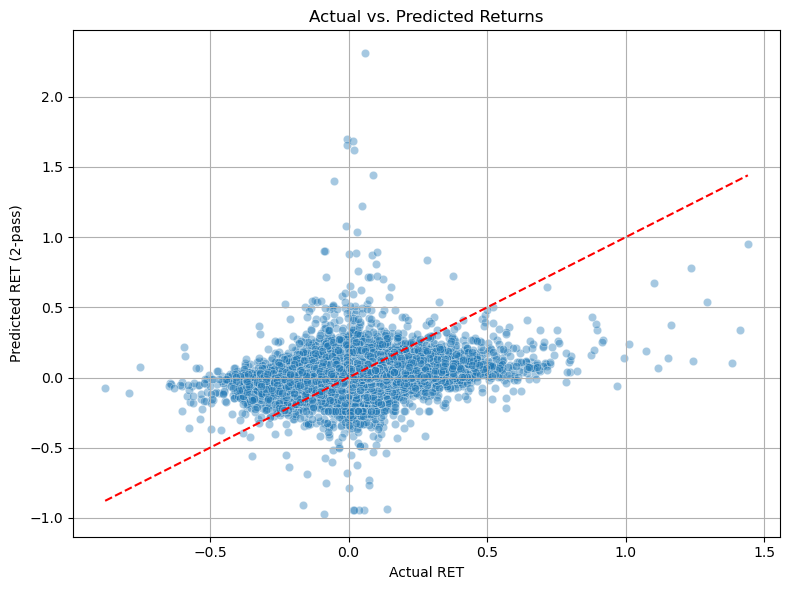

In [ ]:
from tqdm import tqdm

yyyymm_set = filtered_df[filtered_df["yyyymm"] >= 201001]["yyyymm"].unique()

oos_df["predicted_RET_twopass"] = np.nan
for date in tqdm(yyyymm_set):
    # Define 6-year rolling window
    window_start = date - 600

    # Get in-sample data for training
    backtest_slice = oos_df[
        (oos_df['yyyymm'] >= window_start) &
        (oos_df['yyyymm'] <= date)
    ].dropna(subset=oos_df.columns[:-1], axis=0)

    # Loop over each permno **in the current backtest window**
    for permno, group in backtest_slice.groupby("permno"):
        # Not all stocks have data at `date`, so check for prediction row
        row = oos_df[(oos_df['permno'] == permno) & (oos_df['yyyymm'] == date)]
        if row.empty:
            continue

        idx = row.index[0]
        X = group[final_factor_names]
        y = group["RET"]

        # if len(X) < 30 might be better
        if len(X) < 20:  # Not enough data to regress
            oos_df.loc[idx, "predicted_RET_twopass"] = group['RET'].mean()
            # If not enough data, set the predicted return as the mean return.
            continue

        model = linear_model.LinearRegression().fit(X, y)
        prediction = np.dot(row[final_factor_names].values[0], model.coef_) + model.intercept_

        # Write prediction
        oos_df.loc[idx, "predicted_RET_twopass"] = prediction

# print(results)
# print(actual)

# drop missing
results = oos_df[["RET", "predicted_RET_twopass"]].dropna()
actual = results["RET"]
pred = results["predicted_RET_twopass"]

# evaluation
rmse = np.sqrt(mean_squared_error(actual, pred))
mae  = mean_absolute_error(actual, pred)
r2   = r2_score(actual, pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"OOS R-squared: {r2:.4f}")

# scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=actual, y=pred, alpha=0.4)
mn, mx = actual.min(), actual.max()
plt.plot([mn, mx], [mn, mx], "--r")
plt.xlabel("Actual RET")
plt.ylabel("Predicted RET (2-pass)")
plt.title("Actual vs. Predicted Returns")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
oos_df

,permno,yyyymm,IM,range_20,log_vol_dollar_20,range_120,log_vol_dollar_120,xret_5,xret_10,xret_20,...,VOL,RET,SHROUT,log_vol_dollar_120_z,BM_z,mdr_z,xret_indsize_std20_z,MoneyFlowIndex_120_z,xret_indsize_20_z,predicted_RET_twopass
216,10026.0,200401.0,0.078022,0.027681,13.587178,0.027723,13.266448,0.006227,0.005858,0.004070,...,11029.0,0.114936,8801.0,-1.093821,0.006275,-0.672899,-0.540806,-0.974245,0.240341,NaN
217,10026.0,200402.0,0.108668,0.040405,14.394102,0.029569,13.366074,0.064044,0.082999,0.091038,...,5884.0,0.122565,8801.0,-1.088861,0.002518,0.030507,0.486256,0.670854,1.226511,NaN
218,10026.0,200403.0,0.108847,0.056707,14.100279,0.033175,13.493136,0.056408,0.060940,0.164766,...,5863.0,-0.044012,8906.0,-1.072006,0.030748,1.283132,2.355218,0.929994,1.605294,NaN
219,10026.0,200404.0,0.169770,0.031389,13.901639,0.033556,13.689670,-0.032502,-0.021633,-0.023651,...,8986.0,-0.165339,8911.0,-1.012131,0.040861,0.168821,0.325846,0.381055,-0.797685,NaN
220,10026.0,200405.0,0.170133,0.043757,14.311199,0.035777,13.911092,-0.019908,-0.044698,-0.131069,...,8068.0,0.048263,8911.0,-0.932477,-0.033143,1.879751,1.686118,-0.604481,-2.098352,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440715,93429.0,201908.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146067.0,0.093404,111682.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056194
440716,93429.0,201909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,145062.0,-0.035666,111682.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064692
440717,93429.0,201910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,129767.0,0.002089,111682.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066268
440718,93429.0,201911.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156529.0,0.035693,110861.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066115


In [ ]:
oos_bt_df = oos_df[oos_df['yyyymm'] >= 201001]

In [ ]:
def portfolio_weights(df, quantile):
    df['weight'] = 0.0
    for _, group in df.groupby('yyyymm'):
        cl_group = group.dropna(subset=['predicted_RET_twopass'])
        if len(cl_group) == 0:
            continue
        quantile_size = max(int(len(cl_group)*quantile),1)
        sorted_index = cl_group.sort_values(by='predicted_RET_twopass', ascending=False).index

        # Go long equal-weighted portfolio of the top 10%
        df.loc[sorted_index[:quantile_size], 'weight'] = 1.0 / quantile_size
        # Go short equal-weighted portfolio of the bottom 10%
        df.loc[sorted_index[-quantile_size:], 'weight'] = -1.0 / quantile_size
        print("QUANTILE SIZE: ", quantile_size)
    return df

# Return difference for the hedge portfolio
 Compute the return difference for the hedge portfolio between the top score equal-
 weighted 10% portfolio and the bottom score equal-weighted 10% portfolio for each
 month during the testing sample.

In [ ]:
def get_hedge(group):
    long_port = group[group['weight'] > 0.0]
    short_port = group[group['weight'] < 0]
    # NOTE: calculate returns from weights in the case we move from equal-weighted
    # Equal-weighted
    # long_RET = long_port['fwd_RET'].mean()
    # short_RET = -short_port['fwd_RET'].mean()

    # Portfolio weights
    long_RET = (long_port['fwd_RET']*long_port['weight']).sum()
    short_RET = (short_port['fwd_RET']*short_port['weight']).sum()

    hedge_RET = long_RET + short_RET
    return pd.Series({"long_RET": long_RET, "short_RET": short_RET, "hedge_RET": hedge_RET})

# NOTE: long - short
def calculate_hedge_RET(df):
    df['fwd_RET'] = df.groupby('permno')['RET'].shift(-1)
    return df.groupby('yyyymm').apply(get_hedge).reset_index()

In [ ]:
def exec_sample_test(sample_df, quantile=0.1):
    # assign weights for top (bottom) %
    weighted_df = portfolio_weights(sample_df, quantile)
    # get the hedge portfolio returns
    hedge_returns = calculate_hedge_RET(weighted_df)
    return weighted_df, hedge_returns

In [ ]:
weighted_df, hedge_returns = exec_sample_test(oos_bt_df)

C:\Users\germa\AppData\Local\Temp\ipykernel_26940\1973205125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = 0.0


QUANTILE SIZE:  104
QUANTILE SIZE:  104
QUANTILE SIZE:  104
QUANTILE SIZE:  104
QUANTILE SIZE:  104
QUANTILE SIZE:  104
QUANTILE SIZE:  104
QUANTILE SIZE:  104
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  105
QUANTILE SIZE:  106
QUANTILE SIZE:  106
QUANTILE SIZE:  105
QUANTILE SIZE:  106
QUANTILE SIZE:  106
QUANTILE SIZE:  106
QUANTILE SIZE:  106
QUANTILE SIZE:  106
QUANTILE SIZE:  106
QUANTILE SIZE:  107
QUANTILE SIZE:  107
QUANTILE SIZE:  107
QUANTILE SIZE:  107
QUANTILE SIZE:  107
QUANTILE SIZE:  107
QUANTILE SIZE:  107
QUANTILE SIZE:  107
QUANTILE SIZE:  108
QUANTILE SIZE:  108
QUANTILE SIZE:  108
QUANTILE SIZE:  108
QUANTILE SIZE:  108
QUANTILE SIZE:  108
QUANTILE SIZE:  109
QUANTILE SIZE:  109
QUANTILE SIZE:  109
QUANTILE SIZE:  109


C:\Users\germa\AppData\Local\Temp\ipykernel_26940\4226971947.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fwd_RET'] = df.groupby('permno')['RET'].shift(-1)
C:\Users\germa\AppData\Local\Temp\ipykernel_26940\4226971947.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('yyyymm').apply(get_hedge).reset_index()


 ## Compute performance analytics on out-of-sample returns
 You should compute:
 1. Raw return
 2. Sharpe ratio
 3. CAPM alpha
 4. Fama-French 3-Factor alpha
 5. Information Ratio using 3-factor model

In [ ]:
ff_factors = pd.read_excel("ff_factors.xlsx")
ff_factors['yyyymm'] = ff_factors['DATE'].dt.year * 100 + ff_factors['DATE'].dt.month

In [ ]:
def performance_analytics(hedge_returns, ff_factors):
    print("Computed performance analytics on out-of-sample returns")

    print("=== 1. Raw return stats ===")
    returns_data = hedge_returns.copy()
    returns_avg = returns_data['hedge_RET'].mean()
    print(returns_avg)
    returns_ann = (returns_avg)*12
    print(f"Raw return (annualized): {returns_ann:.4%}")

    # merge hedge dataframe with Fama-French factors
    merged_data = pd.merge(returns_data, ff_factors, on='yyyymm', how='inner')

    print("=== 2. Sharpe ratio ===")
    merged_data['excess_hedge_RET'] = merged_data['hedge_RET'] - merged_data['RF']
    excess_return_mean = merged_data['excess_hedge_RET'].mean()
    excess_return_std = merged_data['excess_hedge_RET'].std()
    sharpe_excess = excess_return_mean / excess_return_std * np.sqrt(12)
    print(f"Sharpe ratio (annualized): {sharpe_excess:.4f}")

    # CAPM model stuff
    print("=== 3. CAPM Model ===")
    capm_independent = sm.add_constant(merged_data['MKTRF'])
    capm_dependent = merged_data['excess_hedge_RET']
    capm_model = sm.OLS(capm_dependent, capm_independent).fit()
    capm_alpha_tstat = capm_model.tvalues['const']
    capm_alpha = capm_model.params['const']
    print(f"CAPM alpha (monthly): {capm_alpha:.4%}")
    print(f"CAPM alpha t-stat: {capm_alpha_tstat:.4f}")
    print(f"CAPM R-squared: {capm_model.rsquared:.4f}")

    # Fama-French 3-factor model
    print("=== 4. Fama-French 3-Factor Model ===")
    ff3_independent = sm.add_constant(merged_data[['MKTRF', 'SMB', 'HML']])
    ff3_dependent = merged_data['excess_hedge_RET']
    ff3_model = sm.OLS(ff3_dependent, ff3_independent).fit()
    ff3_alpha_tstat = ff3_model.tvalues['const']
    ff3_alpha = ff3_model.params['const']
    print(f"FF3 alpha (monthly): {ff3_alpha:.4%}")
    print(f"FF3 alpha t-stat: {ff3_alpha_tstat:.4f}")
    print(f"FF3 R-squared: {ff3_model.rsquared:.4f}")

    # compute information ratio
    print("=== 5. Information Ratio (FF3) ===")
    ff3_residuals = ff3_model.resid
    tracking_error = ff3_residuals.std()
    information_ratio = ff3_alpha / tracking_error * np.sqrt(12)
    print(f"Information Ratio (annualized): {information_ratio:.4f}")

In [ ]:
performance_analytics(hedge_returns, ff_factors)

Computed performance analytics on out-of-sample returns
=== 1. Raw return stats ===
-0.004522411647813435
Raw return (annualized): -5.4269%
=== 2. Sharpe ratio ===
Sharpe ratio (annualized): -0.8942
=== 3. CAPM Model ===
CAPM alpha (monthly): -0.5822%
CAPM alpha t-stat: -3.2174
CAPM R-squared: 0.0243
=== 4. Fama-French 3-Factor Model ===
FF3 alpha (monthly): -0.5642%
FF3 alpha t-stat: -3.0580
FF3 R-squared: 0.0297
=== 5. Information Ratio (FF3) ===
Information Ratio (annualized): -1.0345


In [ ]:
# def validate_weights(weighted_df):
#     results = []
#     for _, group in weighted_df.groupby('yyyymm'):
#         long_sum = group[group['weight'] > 0]['weight'].sum()
#         short_sum = group[group['weight'] < 0]['weight'].sum()
#         results.append({
#             'valid?': (abs(long_sum - 1.0) < 0.01) and (abs(short_sum + 1.0) < 0.01),
#             'yyyymm': date,
#             'long_sum': long_sum,
#             'short_sum': short_sum,
#         })

#     validation_df = pd.DataFrame(results)
#     print(f"Total periods checked: {len(validation_df)}")
#     print(f"Valid periods: {validation_df['valid?'].sum()}")
#     print(f"Invalid periods: {len(validation_df) - validation_df['valid?'].sum()}")
#     # Show any invalid periods
#     if len(validation_df) - validation_df['valid?'].sum() > 0:
#         print("\nInvalid periods:")
#         print(validation_df[~validation_df['valid?']])

#     return validation_df

# validation_results = validate_weights(weighted_df)